In [1]:
import os.path
import seaborn as sns
import re
import pandas as pd

In [2]:
DATA_DIR = '../../data/data_processed/'

In [35]:
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_colwidth', 50)

In [3]:
articles = pd.read_csv(DATA_DIR + 'data_processed_before_death_cleaning.csv', index_col=0)
articles.index.names = ['id']

In [4]:
articles['n_death'] = 0

In [52]:
def extract_deaths(_raw_str):    
    raw_str = re.sub(r'{.*?}','',str(_raw_str)) # questo è estremo, ne abbiamo veramente bisogno?
    raw_str = re.sub(r'isbn=\d{1,99}|{isbn[|]\d.*?}', '', raw_str)
    raw_str = re.sub(r"(?:(?:https?|ftp):\/\/|\b(?:[a-z\d]+\.))(?:(?:[^\s()<>]+|\((?:[^\s()<>]+|(?:\([^\s()<>]+\)))?\))+(?:\((?:[^\s()<>]+|(?:\(?:[^\s()<>]+\)))?\)|[^\s`!()\[\]{};:'\".,<>?«»“”‘’]))?", '', raw_str)
    raw_str = re.sub(r"\|\d{1,9}\||\|\d{1,9}\.\d{1,9}em\||\d{1,9}\.\d{1,9}em\||page.\d{1,9}|p\..\d{1,9}",'',raw_str)
    raw_str = raw_str.replace(".",",")
    raw_str = raw_str.replace("+","")
    raw_str = raw_str.replace(" million","000000 ")
    raw_str = raw_str.replace(" housand","000")
    raw_str = raw_str.replace(" hundred","00")
    raw_str = re.sub(r"\d{1,9}((,|')\d{3})(.\d+)?([-–]| to | [-–] | [-–])\d{1,9}((,|')\d{3})([,']\d+)?(\s|[A-z])*displaced|\d{3}([-–]| to | [-–] | [-–])\d{3}([,']\d+)?(\s|[A-z])*displaced",'',raw_str)
    raw_str = re.sub(r"\d{1,9}((,|')\d{3})*(\.\d+)?(\s|[A-z])*displaced",'',raw_str)
    
    regex_nbrs = re.compile(r"\d{1,9}((,|')\d{3})*(\.\d+)?")
    regex_casu1 = re.compile(r".*\|caus2\|")
    regex_casu2 = re.compile(r"\|caus2\|.*")
    regex_rngs = re.compile(r"\d{1,9}((,|')\d{3})(.\d+)?([-–]| to | [-–] | [-–])\d{1,9}((,|')\d{3})([,']\d+)?|\d{3}([-–]| to | [-–] | [-–])\d{3}([,']\d+)?")
    
    if(raw_str == 0):
        return 0;
    
    def extractAllExtr(stringa):
        allExtr = [];
        for match in regex_nbrs.finditer(stringa):
            allExtr.append(match.group(0))
        
        if(len(allExtr) < 1):
            return 0

        rng1 = -1
        rng2 = -1
        for match in regex_rngs.finditer(stringa):
            rng = match.group(0)
            rng_split = (rng.replace(',','')
                            .replace("'","")
                            .replace("–","-")
                            .replace(" - ","-")
                            .replace(" to ","-").split("-"))
            rng1 = int(rng_split[0])
            rng2 = int(rng_split[1])
            if(rng1>=rng2):
                continue

            rng_sum = str(int((int(rng_split[0])+int(rng_split[1]))/2));
            allExtr.append(rng_sum)

        #cleaning: 
        #allExtr = [ x for x in allExtr if "." not in x ]
        allExtr = [extr.replace(',', '').replace("'","") for extr in allExtr]
        allExtr = [int(i) for i in allExtr]
        allExtr = [ x for x in allExtr if x not in [rng1,rng2] ]

        if(len(allExtr) == 1):
            return allExtr[0]

        def shouldGetMax(stringa,lenExtr):
            toExclude = re.compile(r"(at least|total|over [0-9])",re.IGNORECASE)
            if(toExclude.search(stringa)):
                return True
            if(lenExtr >=5): #5 numero arbitrario
                return True
            return False

        if shouldGetMax(stringa, len(allExtr)):
            return max(allExtr)

        return sum(i for i in allExtr)
    
    print(raw_str)
    if(regex_casu2.search(raw_str)):
        print('----------------')
        casu1Deaths = regex_casu1.search(raw_str)
        casu1Deaths = extractAllExtr(casu1Deaths.group(0))
        print("caus1: "+ str(casu1Deaths))
        
        casu2Deaths = regex_casu2.search(raw_str)
        casu2Deaths = extractAllExtr(casu2Deaths.group(0))
        print("caus2: "+ str(casu2Deaths))
        
        casuAllDeaths = casu1Deaths+casu2Deaths
        print("causAll: "+ str(casuAllDeaths))
        return casuAllDeaths
    
    casuAllDeaths = extractAllExtr(raw_str)
    return casuAllDeaths
    
    

In [53]:
articles["n_death"] = articles["death"].apply(extract_deaths)

70000
828000
0
230
24968
3663
0
10786
868374
41000
0
113300
895
712
2
2203
0
23049
1000
0
30000
200656
0
2500
11867
14
0
225000
1909
50000
6
82
450700
2013
5750
17000
15000
800000
900


 '''Caused by KLA and NATO:'''<br /> } 1,035 killed (per the HLC)
----------------
caus1: 2057
caus2: 302
causAll: 2359
566434
168
1000000
0



* '''260 to 365'''
----------------
caus1: 45000
caus2: 2
causAll: 45002
225
0
2000
950000
0
0
2061
300400
4517
3968
45088
300000
UDA: 91<br />UVF: 62<br />RHC: 4<br />LVF: 3<br />UR: 2 <br />'''Total''': 162
2001
0
96
0
950765
73000000
55000
111132
60600
500000
70000
20000
0
12773
222
0
800
1666
10400
1750
70
70000
0
15
7

''United States claimed'': 200–800 killed
----------------
caus1: 99
caus2: 25
causAll: 124
44000
0
289203
324307
0
10454
0
0
0
0
586000
120024
14500
1000
223513
0
40
0
4000
400000
17287
25306
24000
36798
12738
0
17843
0
0
0
500
3300
200
8000
4400
3798
20407
0
385000
7500000
0
0
3960
0
2002
28924
1153
200000
0
126000
621
16263
0
0
1500
16
0
9

1000
210
2326
600
14
1700
0
7
1
0
1100
0
38
10000
5300
15000
250
0
0
95
0
18500
900
6450
0
12560
0
47
25
21
6831
43
1001
6300
170
33
2906
14300
2000
1336
16200
4628
1800
6344
23511
8300
2762
20050
934
374
10000
1200
24190
1600
2200
17 killed
0
3800
0
18
121
0
1300
0
654
486
3967
0
211
850
100
91
50
0
3
257
3171
0
0
80000
8808
10024
0
111
0
80
8
1500
Unknown
106
900
67
0
0
540000
11
402
299
200
4000
130
0
0
1800
2306
370
0
13
1083
171
8452
6118
437
2000
220000
331247
3876
None |caus2| 6 } –50 militants killed<br /> } 1 killed, 10 injured } <br /> } 5 [[Inter-Services Intelligence|ISI]] officers killed }
----------------
caus1: 2
caus2: 50
causAll: 52
7500
6444
4850
4120
0
31097
2696
1000
2
688341
10000
70000
800
272642
1602
35000
4258
19
0
71636
119
28
826
3000
0
28
34
0
10000
4
5
3000000
1194
17700
14000
1583
1273
40000
2012
1300
2904
1500
368
0
124
187
201
100
22
} 1 killed |caus2| } 100-200 killed
----------------
caus1: 3
caus2: 152
causAll: 155
6781
62000
0
0
200
2325
5353
399
500


192
1
0
21
12
170
0
39303
21
0
0
0
4700
6,703 killed (2004–2017) <br />11,919 injured (2004–2015)
252
2027
0
77
0
150
700
150
0
0
0
0
0
107
2600
240
85
0
2512
650
973
0
19536
0
0
0
270
374
2660
143
67
0
1243
526
0
500
1500
0
30000
24
55000
0
11,500&ndash;15,000 [[Croatian Serb]] refugees <br>3 UN peacekeepers wounded
7530
13000
821
2000
300
2900
0
0
3
1
39
1200
0
11700
19 killed<br />1 wounded<br />1 Chinook helicopter shot down |caus2| Unknown, with the highest estimate 35 killed
----------------
caus1: 23
caus2: 37
causAll: 60
1
158118
0
0
0
10
3
Over 50,000 civilian deaths
604
500
0
10
0
6575
23
0
0
4600
256000
48
422
222
6000
0
0
0
Between 50,000–300,000 killed <br> internally and externally
107
6002
0
3716
0
6
150
0
1335
1600
0
1060
0
8
2
2000
0
0
0
17
0
100000
0
1000
0
59
11
87
0
20000
31
43
0
0
1991
1000
1000
0
347
0
0
0
10
1152
0
9000
0
732
13040
0
? |caus2| 1,200-8,500 killed } } <br>200 captured }
----------------
caus1: 2
caus2: 5052
causAll: 5054
0
31
100
229
891
876
297
40

0
1200
0
0
0
0
0
0
7 Lebanese civilians killed <small>(Lebanese sources)</small>
0
0
0
249
18
1
0
4300
0
0
1500
6
6
0
56
7
1 Israeli civilian killed and 157 Israeli civilians wounded <br />
Lebanese civilian casualties unknown
0
143
200
2700
45
1
1200
4
67
0
0
324
0
0
36
1100
41
0
42
0
183
85493
2800
0
0
359–431 killed<br>300 captured<br>1,000 wounded |caus2| 32 killed<br>60 wounded<br>6 captured<br>15 vehicles destroyed<br> 8 [[Amphibious Assault Vehicles|AAVs]] destroyed
----------------
caus1: 1697
caus2: 60
causAll: 1757
0
0
3500
0
0
1000
137
0
1550
1657
10
100
141
544
524
568
88
262
0
144
105
0
0
0
2033
0
0
0
0
Unknown |caus2| 275 servicemen killed,<br>15 missing and 937 wounded<small> (Russian claim)</small> <br>significant losses to local Dagestani police and militias
----------------
caus1: 2
caus2: 1229
causAll: 1231
1921
1000
90 civilians killed, 150–250 total dead and 1,000 total casualties <br>
70–250 killed in fighting <br> 
'''Other''':<br>
 <br> } Three EU monitors kille

24
0
300000
2
30–40 killed<br/>450 captured |caus2| 14 killed
----------------
caus1: 522
caus2: 16
causAll: 538
-
3512
314
3948
0
0
0
550
0
16000
2050
0
300
0
0
224
60
0
0
17
6
13000
0
800
5
0
6
4000
0
1301
12000
12162
0
9328
11
0
0
0
40
0
0
156000
0
18
1111
0
0
7,482 civilians killed
0
0
72
160
9758
0
82000
173
2
0
1375
421
146
0
0
0
69000
10
0
5
0
227
0
8
0
125000
30000
50
0
8
0
6
715
70
18500
40000
0
3800
5 killed, 25 wounded |caus2| 150 killed, 20 captured
----------------
caus1: 32
caus2: 172
causAll: 204
0
5945
465
8
100
2691
0
42
0
0
0
918
0
68
0
1963
1
0
188
6000
11–25 killed (Iraqi forces)<br/> 2 killed (U,S,)<br/>1 [[AH-64]] [[List of aviation accidents and incidents during the Iraq War|shot down]] |caus2| 263 killed, 407 captured (actual count by US Forces conducting detainee operations post battle)
----------------
caus1: 64
caus2: 672
causAll: 736
2
300 Afghans dead  and 1 American killed |caus2| 86 re-captured, the rest killed
----------------
caus1: 303
caus2: 88
causAl

6
0
260
0
0
11
6000
0
1
5
0
Unknown
0
1205
0
6200
0
2000
7
200
564
388
0
0
360
4227
0
0
144
0
1
72
1000
0
0
0
6
409
0
24
0
98
0
1350
0
250
1000
0
800–1,500 killed <br />
90
0
0
0
0
0
5
12
15000
8
0
10000
4001
40
30
0
0
10700
20
0
130
0
0
300
13000
0
0
5000
0
0
0
0
0
0
33000
0
121
0
0
96
6
2600
4153
217
3000
0
0
0
0
0
600
13
110000
0
2000
1160000
0
150
0
0
0
0
0
0
548 civilians killed
1
2000
0
0
9
527
1000
'''Civilian casualties''':<br /> At least 160 killed and 1,000 wounded ([[Red Cross]]) <br />At least 100 killed and 700 wounded ([[Médecins Sans Frontières|MSF]]) <br />At least 400 killed (President Déby) '''Total casualties:'''<br/>540 killed (Uppsala Conflict Data Program) <br />700 killed, including those killed in [[Massaguet]] (President Déby)
2767
340
0
5
3100
0
0
3
0
1915
516
0
0
62
10
0
3
1693
5
440
7
1800
0
0
189
69
0
19
37
0
2200
0
0
3800
10
0
0
0
121
6
150
20
1097
0
0
0
Estimates range from 100,000–300,000 dead ([[Indonesian occupation of East Timor#Number of deaths|see b

11
0
0
3
8 civilians killed
214
0
12
17
0
3
0
0
0
0
0
68
0
128
0
50
10
0
47
0
4
42
1000
0
0
0
0
0
67
270000
10
0
0
Dozens of houses destroyed according to the [[Israel Defense Forces|IDF]] <br />according to [[Human Rights Watch|HRW]] at least 140 buildings completely destroyed, severe damage caused 200 additional buildings rendered uninhabitable or 
5
0
0
110
'''Total: 669–979 fatalities:'''<br>429–673 fatalities (Uppsala data 2005–09, 2011)<br>669–979 casualties (2004–15, see [[Iran–PJAK conflict#Secondary source reports summary|below]])
0
3000
0
237
4
4
0
0
0
5
0
0
0
0
10
76000
0
76
0
230
0
0
111
28
71651
0
65
11
17
26
2
1 German soldier wounded
0
2250
0
0
394
2
130
100 civilians killed
4500
0
81
30
0
0
0
0
0
1
0
310
135
0
0
0
108
86
21
0
351
1200
394
0
12
0
0
0
0
2
37
400
275
None |caus2| 1 dhow captured<br>3 killed<br>8 captured
----------------
caus1: 2
caus2: 14
causAll: 16
0
203
0
0
0
101
3
66
0
650
961
800
0
800 killed overall between 2002 and November 2008 <br>71 civilians ki

0
90
13000
900
0
27
0
0
0
~100 killed in total<br>168,000 civilians [[Displaced person|displaced]]
377
0
1
50
0
15
0
0
80
23000
0
197
175
0
0
41
1100
0
0
[[Death of Seyed Ali Mousavi|Seyed Ali Mousavi]]
0
83
11
0
0
8
5
43
0
31
186
1
67
3
0
6
24
0
10
105
1884
0
9
0
10
600
0
25 killed (Ethiopian Claim) |caus2| 10 killed (Eritrean Claim) <br>2 captured<br>
----------------
caus1: 27
caus2: 14
causAll: 41
0
34
2
1
54
0
0
5100
0
0
200
7
0
0
6 wounded |caus2| 150 killed
----------------
caus1: 8
caus2: 152
causAll: 160
0
4
0
0
4
0
3
0
17
1000
6
0
0
10000
126
0
0
2
0
0
87
4
15
0
5000
4
300
0
0
26
0
0
0
at least 96 (2010) <br> at least 290 (2011) <br> at least 248 killed (January–March 2012) <br> at least 54 killed (since April 2012 and 2nd Battle of Lawdar) <br> at least 78 killed (since May 2012) <br>'''Total killed: 886''' 
---- } : 17 sailors killed, 39 injured during [[USS Cole bombing]]<br> } : 2 border guards killed
25 dead<br>75 wounded
75
1050
0
0
0
0
11
[[Google]] [[intellectual prop

----------------
caus1: 302
caus2: 52
causAll: 354
36
0
28
3900
0
0
5000
0
0
0
43
0
32
49
15
3
10000
1
34
0
90
3
39
11
0
162
0
0
0
0
11000
0
128
0
0
0
532
3
0
160
0
5
9
344
8
0
152
100
260
688
0
852
0
0
0
0
1409
0
0
0
55
0
0
1 civilian killed <br>over 100 people injured, <br>117 arrested |caus2| 62 constables injured, <br>at least 3 soldiers injured,<br>some armoured vehicles badly damaged or destroyed
----------------
caus1: 117
caus2: 62
causAll: 179
0
300
0
0
0
0
0
0
0
1784
0
0
6
0
1100
37
0
0
60
0
0
2
2
60
0
0
0
150
6
0
85
224
0
28 killed, 44 wounded |caus2| 51 killed
----------------
caus1: 74
caus2: 53
causAll: 127
16
0
77
0
0
4
32
0
3
1000
45000
0
189
3000
200
1200
0
0
9300
0
45
0
0
0
0
317
323
'''Civilians''' <br /> 7 wounded
400
0
0
1
0
160
0
0
0
0
193
14
18
10
0
0
11
0
0
900
200
34
0
498
129
3000
9000
0
21000
0
0
1668
0
1150
0
140
0
224
0
0
0
0
0
6000
0
1
61
152230
70
0
37
18
6221
0
6
750
81
0
0
400
0
0
0
0
0
0
0
3 killed |caus2| Unknown
----------------
caus1: 5
caus2: 2
cau

128
13
5300
56
0
9
0
0
0
0
118
0
60
4
2
0
930 civilians killed (opposition claims)
0
900
0
3000
1000
0
425
13
} 115 killed<br><small>(Conflict with Tuaregs)</small> ---- } 625 killed<br><small>(French intervention)</small>
600
460
92000
3 killed, 5 wounded |caus2| Officially 11 killed, "several" wounded
----------------
caus1: 10
caus2: 13
causAll: 23
0
0
0
64
2,515-4,026 total killed<br/>424-969 civilians killed
21
0
0
20
0
0
0
0
0
0
52246
0
15
1000
113
0
4
0
0
0
0
160
25396
108
39
424
1
1800
0
0
23
0
100
0
0
0
0
0
0
0
'''Civilian casualties:''' 500 Egyptian, 219 Russians, 4 Ukrainians, 1 Belarusian, 6 Israeli, 4 South Korean, 1 Croatian<br> '''Yamam: '''2 killed <br> '''IDF:''' 1 killed <br>'''Total: 2,371–4,735 killed'''
2 civilians killed, 6  <br/>'''Total: 55 killed'''
2
500
28
2
0
1200
0
0
17279
0
4
9
0
1652
0
600
0
0
513
50
0
0
0
0
0
0
6 killed plus 2 village guards killed |caus2| 140 killed and one captured
----------------
caus1: 10
caus2: 142
causAll: 152
52
0
7
1 killed; 3 w

14
0
0
0
29
14
0
0
0
0
609
12003
0
0
130000
0
170
'''Civilians injured:''' 8
10
11
400
1900
2
0
0
0
48 arrested and 165 injured 13 wounded |caus2| 33–36 injured 6 wounded
----------------
caus1: 228
caus2: 77
causAll: 305
3
12
0
0
13
40
3
11
0
0
0
14
83
0
0
56652
0
0
4
0
41
158
0
0
0
0
0
0
145
0
105
0
2500
90
0
32
0
0
0
0
18
200
18
0
0
14
18
0
1094
121
59
0
Over 8,000 killed overall <br>(including 304 foreign civilians)
0


For more information see [[Casualties of the Ukrainian crisis]]
11
0
76
1850
0
0
0
0
600
1
0
14
8
32
0


~10 killed |caus2| ~100 killed, 30 captured
----------------
caus1: 12
caus2: 132
causAll: 144
4
400
17
12000
0
0
0
0
1025
0
3 civilian deaths (2 pro-Russian and 1 pro-Ukrainian) }
0
1 killed<br>3-6 wounded<br><small>(according to Mali)</small><br>30 killed<br>2 tanks destroyed<br>6 vehicles destroyed<br><small>(according to the MNLA)</small> |caus2| 4 killed<br>3 wounded<br><small>(according to the MNLA)</small><br>7 killed<br>20 wounded<br><small>(according to 

12
24
2150
2
0
0
0
0
5
1
9
0
235
7
1 killed <br> 1 injured |caus2| 143 killed
----------------
caus1: 4
caus2: 145
causAll: 149
0
12
18000
''Civilian casualties''' <br />No widely agreed-on 
20
0
2
0
0
3
2000
0
0
81000
0
170
189
15
0
12773
0
0
0
5
3
108
0
44
0
31
0
0
0
77–97 killed<br> |caus2| 17 killed
----------------
caus1: 176
caus2: 19
causAll: 195
0
223
0
500 civilians killed (separatist claim)
Civilian Casualties <br> at least 1 killed and 1 injured <small>(media report)</small> <br> at least 7 killed and 3 injured <small>(Suara Bangsamoro claim)</small>
10
0
* 180 arrested * 20 injured |caus2| * 92 policemen injured
----------------
caus1: 202
caus2: 94
causAll: 296
0
0

62 |caus2| Unknown
----------------
caus1: 64
caus2: 2
causAll: 66
1
0
0
60
0
0
0
3184
128
8
0
172
0
0
0
8 killed |caus2| 1 wounded
----------------
caus1: 10
caus2: 3
causAll: 13
713
0
0
1
0
61
Several  civilians killed
'''Total casualties:''' 48 dead, 247 injured (27 shot, 31 stabbed) and 99 hospitalised <br>

caus1: 2
caus2: 3
causAll: 5
0
3
2
3
20
2
0
4
1000
0
0
14
7
14
3
3
0
3
0
0
0
1183
0
16
} 112 soldiers killed <small>(12–25 Jan, & 26 Feb, 2016)</small> <br> } 3 soldiers killed <br>1 Su-24M bomber shot down <br>1 Mi-8AMTsh helicopter destroyed |caus2| 302 killed (124 foreigners)
----------------
caus1: 2016
caus2: 428
causAll: 2444
0
0
0
0
12 civilians killed
0
17
'''Total:''' 772 killed
0
23
0
0
0
0
72
3304
565
7
61
0
60
16
2
90
16
23
3 German paratroopers wounded<br/>3 US soldiers wounded<br/>2 German armoured fighting vehicles damaged<br/>1 US minesweeping vehicle damaged |caus2| 12 killed
----------------
caus1: 3
caus2: 14
causAll: 17
0
0
348
12
None |caus2| Unknown
----------------
caus1: 2
caus2: 2
causAll: 4
500
0
28
120
0
0
6 Peshmerga fighters killed and 4 Turkish soldier wounded |caus2| 250 ISIL fighters killed
----------------
caus1: 12
caus2: 252
causAll: 264
0
39
0
0
1191
6
110
0
0
1
118
0
SDF: 9 killed |caus2| 319 killed
----------------
caus1: 11
caus2: 321
causAll: 332

caus2: 160
causAll: 162
7 civilians killed <br> <br>3 - 100 evacuees died
608
200 civilian casualties <br>
0
2
89 rebels and 1 Turkish soldier killed |caus2| 183–210 killed
----------------
caus1: 92
caus2: 198
causAll: 290
100–170 fighters killed on both sides
0
82
2
32
<br>Unknown civilians killed<br>Unknown civilians wounded<br>'''Second Afar Insurgency'''<br>5 civilians killed<br>23 civilians kidnapped<br>3 civilians wounded
----
'''Total'''<br>70,741–98,965 killed
200
0
3
0
462
0
0
0
0
2
105
0
79
800
1500
1500
6,340 civilians killed and 17,124 injured <small>(as of mid-March 2017, per observer Joel Wing)</small> <br />8,000 civilians killed or injured <small>(as of 5 May 2017; per [[The Daily Telegraph|''The Telegraph'']])</small> <br>5,805 civilians killed <small>(19 Feb,–19 June 2017, by Iraqi/Coalition strikes, per [[Amnesty International|AI]])</small> <br>9,606–11,000 civilians killed <small>(per [[Associated Press|AP]])</small> <br>40,000 civilians killed <small>(per [[Asayis

0
2
1
50
0
2
0
6
2
3062
7600
51
0
9
0
2
129
8
30
0
13
6000
0
5000
2
35
0
200
0
18
6
1
5
80
0
84
18
1
0
} } Unknown<br> } <br>2 killed<br>1 wounded |caus2| 20 killed or captured
----------------
caus1: 5
caus2: 22
causAll: 27
5
0
1000
1
1
0
17
0
3
0
57
1
0
0
0
500
52
12
0
2
0
0
0
0
0
1 civilian killed
12
0
0
0
0
34
5
0
0
110
0
288
73 civilians killed
6
0
0
450
Several killed } } |caus2| 12 killed, several wounded }
----------------
caus1: 2
caus2: 14
causAll: 16
1
35
5
0
57
0
36


* 6 soldiers *5 civilians
----------------
caus1: 32429
caus2: 3
causAll: 32432
7
10
324
7 killed<small>(1 died of wounds)</small><br>6 wounded |caus2| none
----------------
caus1: 16
caus2: 2
causAll: 18
8
6
14 killed } <br/> 30 killed } |caus2| ''' } :'''<br/>4 killed, 6 wounded } <br/> 46 killed } <br/> 59 killed } ''' } :'''<br/> 1 killed, several wounded }
----------------
caus1: 46
caus2: 59
causAll: 105
5
0
0
1
0
0
0
0
0
2
3
1
0
0
28
1
1
395
0
0
0
0
0
359
1
0
19
12
Approx 262 fatal injuries
9
4
435
25
4

In [54]:
articles[articles.death.str.contains('\|caus2\|')].sort_values(by=['n_death'],ascending=False)

,title,categories,article_lenght,views,refs_count,link_count,death,locations,end_date_clean,ongoing,n_death
id,,,,,,,,,,,
1781189,Eritrean–Ethiopian War,military conflict,67289.0,470240.0,117.0,155.0,"19,000 killed <br><small>(Eritrean claim)</sma...",Eritrea Q986|Ethiopia Q115,2000.0,False,470002
8442323,Mexican Drug War,military conflict,200414.0,3151996.0,346.0,522.0,'''Mexico:'''\r\r\n395 servicemen killed and 1...,Throughout Mexico|with occasional spillover...,2006.0,False,146711
17229910,Belgrade Offensive,military conflict,49305.0,117025.0,13.0,262.0,"'''Soviets''':<br>4,350 killed or missing<br>1...",Belgrade Q3711,1997.0,False,63840
12336420,War in North-West Pakistan,"military conflict, military conflict",189509.0,743305.0,262.0,846.0,"'''Pakistan''':<br/>4,302+ to 8,200+ security ...",Federally Administered Tribal Areas Q208270,2004.0,False,59828
10550768,Eelam War IV,military conflict,50807.0,82122.0,77.0,272.0,"6,261 killed (government claim )<br> 29,551 wo...",Sri Lanka Q854,2009.0,False,54316
4512092,Taliban insurgency,military conflict,93544.0,323373.0,181.0,215.0,'''[[List of Afghan security forces fatality r...,Afghanistan Q889,2002.0,False,48245
22738,Operation Enduring Freedom,military conflict,52281.0,1248100.0,60.0,228.0,"{{flagicon|Afghanistan}} '''45,000+''' killed<...",Afghanistan Q889,2014.0,False,45002
54136045,2012–13 escalation of the Syrian Civil War,military conflict,112491.0,15893.0,243.0,253.0,"'''Syrian government'''\r\r\n15,000 –31,174 so...",Syria Q858,2013.0,False,40602
56984243,2018 Gaza border protests,military conflict,232391.0,356582.0,342.0,386.0,"168 dead and 17,259 . or 15,000 injured |caus2...",Gaza Strip Q39760,2018.0,False,32432


In [55]:
articles.sort_values(by=['n_death'],ascending=False)

,title,categories,article_lenght,views,refs_count,link_count,death,locations,end_date_clean,ongoing,n_death
id,,,,,,,,,,,
32927,World War II,military conflict,223212.0,33835972.0,238.0,1456.0,73000000,Russia Q159|Europe Q46|Africa Q15|Pacific ...,1945.0,False,73000000
342641,Pacific War,military conflict,184278.0,2656274.0,190.0,855.0,26000000,Pacific Ocean Q98|Indian Ocean Q1239|East ...,1945.0,False,26000000
4764461,World War I,military conflict,284173.0,31481685.0,254.0,1253.0,17000000,Europe Q46|Australia and Oceania Q55643|Mi...,1918.0,False,17000000
52166101,Mass killings of landlords under Mao Zedong,civilian attack,13778.0,82440.0,18.0,84.0,13875000,People s Republic of China Q148,1976.0,False,13875000
69980,Second Sino-Japanese War,military conflict,157821.0,3596111.0,185.0,737.0,10600000,Mainland China Q19188,1945.0,False,10600000
1120226,Japanese war crimes,civilian attack,155261.0,2004280.0,183.0,614.0,8500000,In and around East Asia and the Pacific,NaN,False,8500000
35053080,"Western Front tactics, 1917",military conflict,152391.0,22484.0,0.0,204.0,7947000,Belgium Q31,1918.0,False,7947000
51499,Western Front (World War I),military conflict,83636.0,1574450.0,0.0,279.0,7500000,Alsace- Lorraine Q155144|Belgium Q31|France ...,1918.0,False,7500000
1014346,Eastern Front (World War I),military conflict,80069.0,1009239.0,66.0,284.0,6500000,Central Europe Q27509|Eastern Europe Q27468,1918.0,False,6500000


In [12]:
articles.loc[[47417586]]

,title,categories,article_lenght,views,refs_count,link_count,death,locations,end_date_clean,ongoing,n_death
id,,,,,,,,,,,
47417586,Battle of Demotika,military conflict,4558.0,15513.0,1.0,33.0,0,Didymoteicho Q932648,1352.0,False,0


C:\Users\Pietro\AppData\Local\conda\conda\envs\ada\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


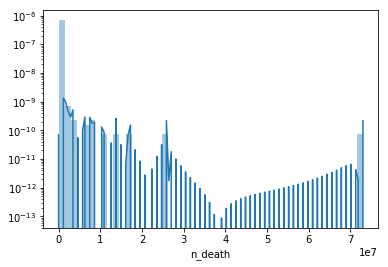

In [31]:
ax = sns.distplot(deaths_pd[deaths_pd["n_death"] != 0]['n_death']);
ax.set_yscale('log')